In [150]:
%%capture
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from src.map_validation.tree_scores import rooted_branch_score, height_score, squared_rooted_branch_score
from src.datasets.load_trees import load_trees_from_file

from tqdm import tqdm

In [151]:
OUTPUT_PATH = Path("data/processed")
PLOTS_PATH = Path("plots/julia_plots")
PLOTS_PATH.mkdir(exist_ok=True)
PREFIX = ""
PLOT_PREFIX = "bio-ccd1"

In [152]:
sns.set_theme(style="darkgrid")
sns.set_context("talk", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})   

In [153]:
colors = [plt.cm.tab20(i) for i in range(12)]
continuous_tab20 = mcolors.LinearSegmentedColormap.from_list("ContinuousTab20", colors, N=256)

gradient = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
palette = [continuous_tab20(c) for c in gradient]
sns.set_palette(palette)

In [154]:
stats_dfs = []

for stats_file in OUTPUT_PATH.glob(f"{PREFIX}*_stats.log"):
    df = pd.read_csv(stats_file, sep=";")
    df["file"] = stats_file.name
    stats_dfs.append(df)

df_stats = pd.concat(stats_dfs)

num_methods = len(df_stats.distribution.unique())

## Entropy

In [155]:
metrics_per_file = (
    df_stats[df_stats.metric.isin(["entropy", "tree_ess", "num_taxa"])]
    .pivot(columns="metric", values="value", index="file")
)
entropy_per_file = df_stats[df_stats.metric == "entropy"].set_index("file").to_dict()["value"]

In [156]:
median_entropy = metrics_per_file.entropy.median()
df_stats["entropy"] = df_stats.file.apply(entropy_per_file.get)
df_stats["high_entropy"] = df_stats.entropy.apply(lambda e: e is np.nan or median_entropy < e)

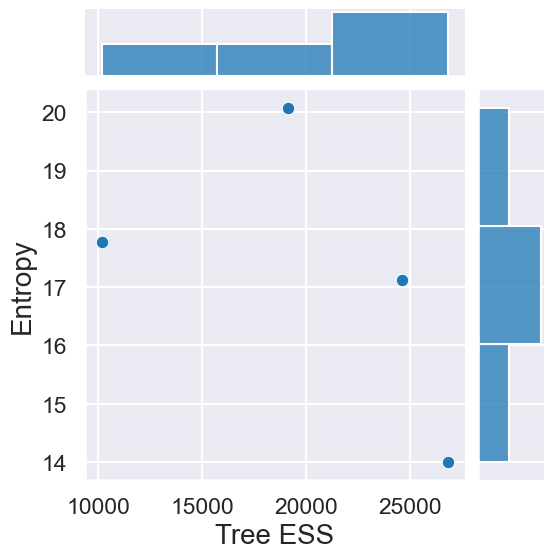

In [157]:
fig = sns.jointplot(data=metrics_per_file, x="tree_ess", y="entropy", kind="scatter")

plt.ylabel("Entropy")
plt.xlabel("Tree ESS")

plt.savefig(PLOTS_PATH / f"{PLOT_PREFIX}-entropy-ess.png", dpi=250)

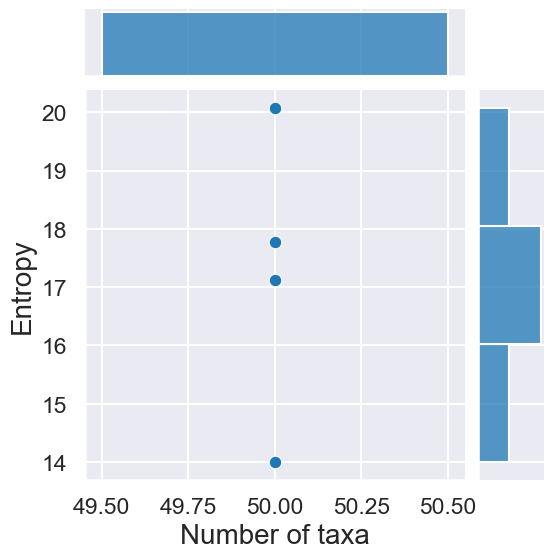

In [158]:
sns.jointplot(data=metrics_per_file, x="num_taxa", y="entropy", kind="scatter")

plt.xlabel("Number of taxa")
plt.ylabel("Entropy")

plt.savefig(PLOTS_PATH / f"{PLOT_PREFIX}-entropy-taxa.png", dpi=250)

## Likelihood Wins

In [159]:
df_stats = df_stats[df_stats["distribution"] != "-"]

df_stats = df_stats.sort_values("value", ascending=False)
df_stats["metric_rank"] = (
    df_stats
    .groupby(["file", "metric"])
    .cumcount() + 1
)

distribution_order = [
    'Height (LogNormal), Ratios (Beta)',
    'Height (LogNormal), Ratios (LogitNormal)',
    'Shortest Branch (Gamma)',
    'Shortest Branch (Weibull)',
    'Shortest Branch (LogNormal)',
    'Last Divergence (Gamma), Branches (Gamma)',
    'Last Divergence (Weibull), Branches (Weibull)',
    'Last Divergence (LogNormal), Branches (LogNormal)',
]

df_stats = df_stats.sort_values("value", ascending=True)
df_stats["inverse_metric_rank"] = (
    df_stats
    .groupby(["file", "metric"])
    .cumcount() + 1
)

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/2160406512.py:7: UserWarning: The palette list has more values (11) than needed (8), which may not be intended.
  ax = sns.displot(


<Figure size 1400x1000 with 0 Axes>

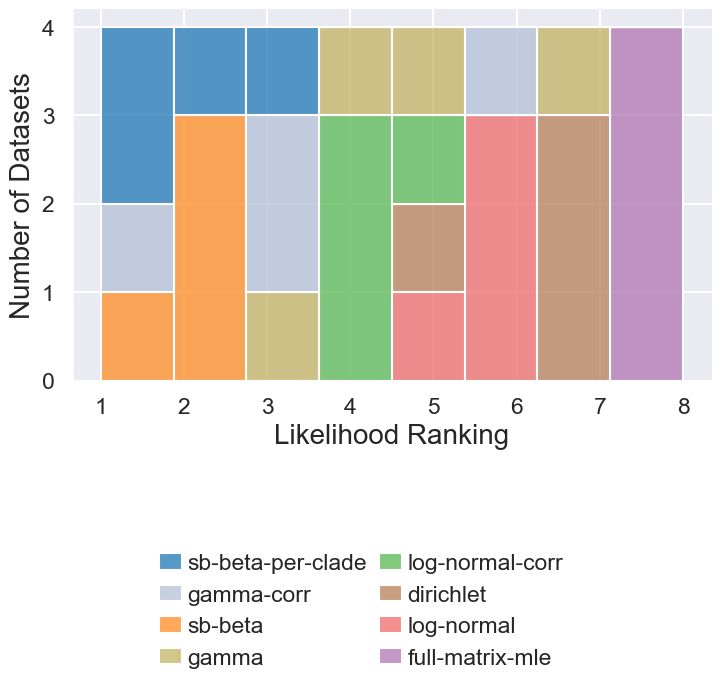

In [160]:
df_likelihoods = df_stats[(df_stats["metric"] == "log_data_likelihood") & (df_stats["value"] != -np.inf)]
df_likelihoods = df_likelihoods.sort_values("metric_rank")
df_likelihoods = df_likelihoods.reset_index()

plt.figure(figsize=(14,10))

ax = sns.displot(
    data=df_likelihoods, x="metric_rank", hue="distribution", multiple='stack', bins=num_methods - 1,
    palette=palette,
)

sns.move_legend(
    ax, "lower center", bbox_to_anchor=(0.5, -0.4), ncol=2, title=None, frameon=False,
    borderpad=0, columnspacing=0.5, handletextpad=0.25, handlelength=1.0
)
plt.xlabel("Likelihood Ranking")
plt.ylabel("Number of Datasets")
    
plt.tight_layout()
ax.savefig(PLOTS_PATH / f"{PLOT_PREFIX}-likelihood-ranking.png", dpi=250)

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/3098962662.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/3098962662.py:3: UserWarning: The palette list has more values (11) than needed (8), which may not be intended.
  sns.boxplot(


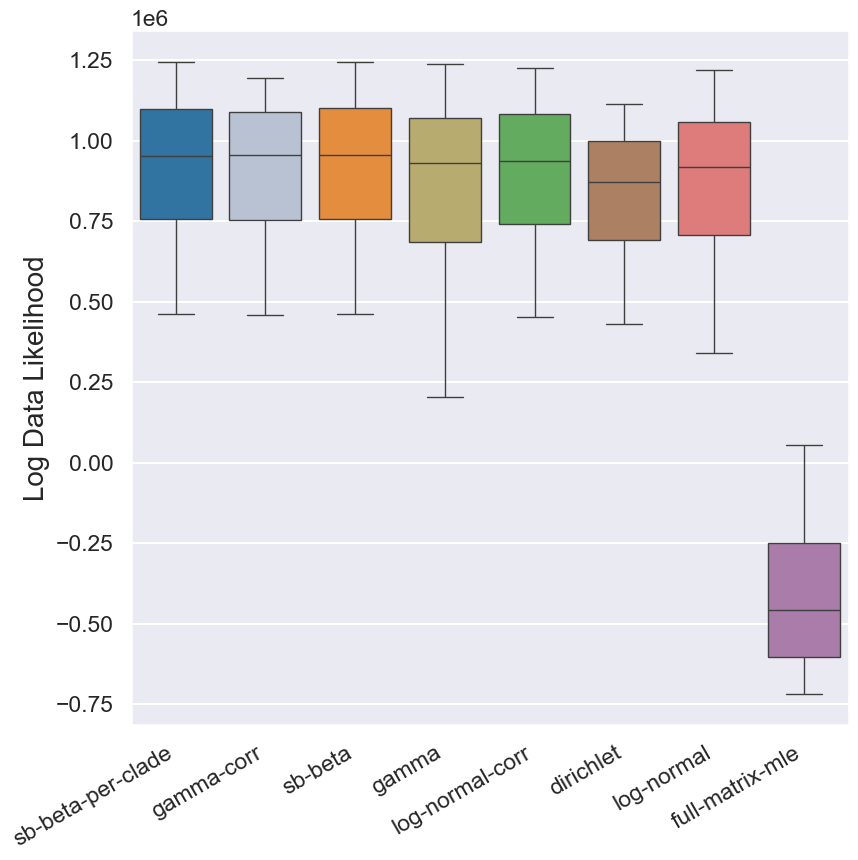

In [161]:
plt.figure(figsize=(9,9))

sns.boxplot(
    data=df_likelihoods,
    x="distribution",
    y="value",
    showfliers=False,
    palette=palette,
)

plt.xticks(rotation=30, ha="right")

plt.xlabel(None)
plt.ylabel("Log Data Likelihood")

plt.tight_layout()
plt.savefig(PLOTS_PATH / f"{PLOT_PREFIX}-likelihood.png", dpi=250)

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/2142988210.py:7: UserWarning: The palette list has more values (11) than needed (8), which may not be intended.
  ax = sns.displot(


<Figure size 1400x1000 with 0 Axes>

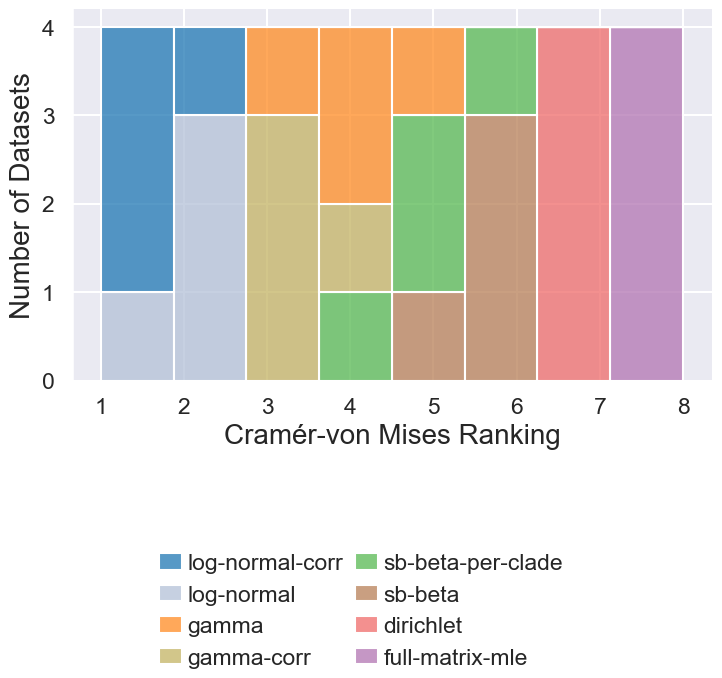

In [162]:
df_cvm = df_stats[df_stats["metric"] == "cramer_von_mises"]
df_cvm = df_cvm.sort_values("inverse_metric_rank")
df_cvm = df_cvm.reset_index()

plt.figure(figsize=(14,10))

ax = sns.displot(
    data=df_cvm, x="inverse_metric_rank", hue="distribution", multiple='stack', bins=num_methods-1, palette=palette
)

sns.move_legend(
    ax, "lower center", bbox_to_anchor=(0.5, -0.4), ncol=2, title=None, frameon=False,
    borderpad=0, columnspacing=0.5, handletextpad=0.25, handlelength=1.0,
)
plt.xlabel("Cramér-von Mises Ranking")
plt.ylabel("Number of Datasets")

plt.tight_layout()
ax.savefig(PLOTS_PATH / f"{PLOT_PREFIX}-cvm-ranking.png", dpi=250)

plt.show()

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/1213680833.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/1213680833.py:3: UserWarning: The palette list has more values (11) than needed (8), which may not be intended.
  sns.boxplot(


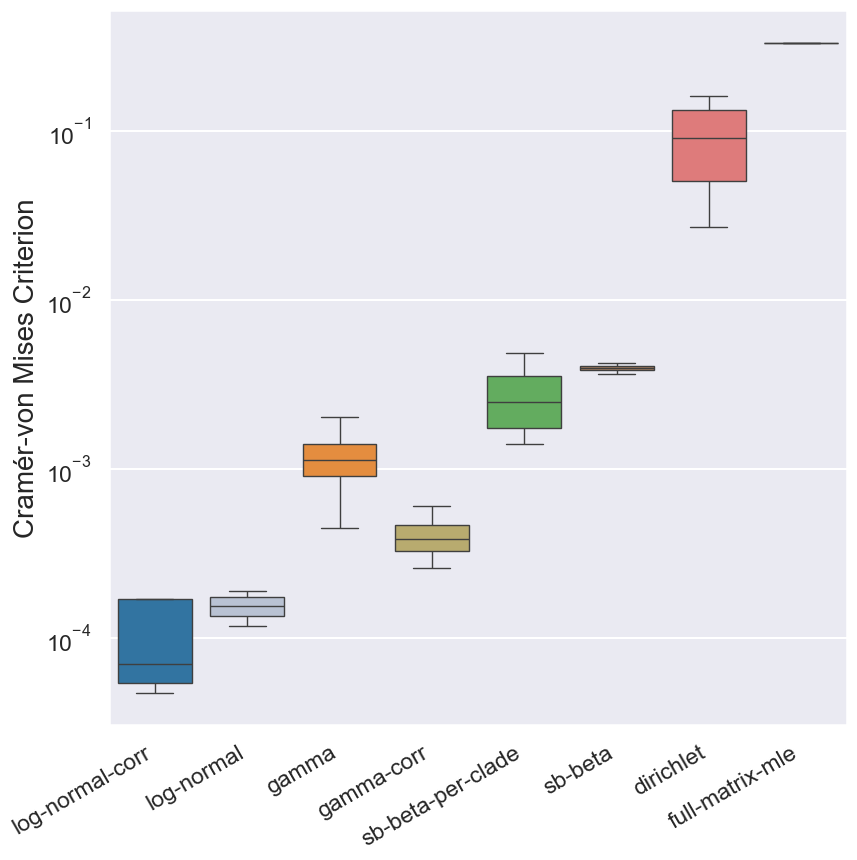

In [163]:
plt.figure(figsize=(9,9))

sns.boxplot(
    data=df_cvm,
    x="distribution",
    y="value",
    showfliers=False,
    palette=palette,
)

plt.xticks(rotation=30, ha="right")

plt.xlabel(None)
plt.ylabel("Cramér-von Mises Criterion")

plt.yscale("log")

plt.tight_layout()
plt.savefig(PLOTS_PATH / f"{PLOT_PREFIX}-cvm.png", dpi=250)

## Model Validation

In [164]:
ecdf_ref_credible_sets_dict = {
    "file": [],
    "distribution": [],
    "credible_set": [],
    "ecdf": [],
}


for credible_sets_file in OUTPUT_PATH.glob(f"{PREFIX}*_estimator_credible_sets.log"):    
    df = pd.read_csv(credible_sets_file, sep=";")
    
    stats_file = OUTPUT_PATH / credible_sets_file.name.replace("_estimator_credible_sets.log", "_stats.log")
    entropy = entropy_per_file.get(stats_file.name, None)
    
    for dist, df_distribution in df.groupby("distribution"):
        ecdf_func = stats.ecdf(df_distribution["sample_credible_set"])
        
        for c in range(101):
            ecdf_value = float(ecdf_func.cdf.evaluate(c / 100))
            
            ecdf_ref_credible_sets_dict["file"].append(credible_sets_file)
            ecdf_ref_credible_sets_dict["distribution"].append(dist)
            ecdf_ref_credible_sets_dict["credible_set"].append(c / 100)
            ecdf_ref_credible_sets_dict["ecdf"].append(ecdf_value)
        
df_ref_credible_sets = pd.DataFrame(ecdf_ref_credible_sets_dict)

dirichlet


/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/4075001225.py:15: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


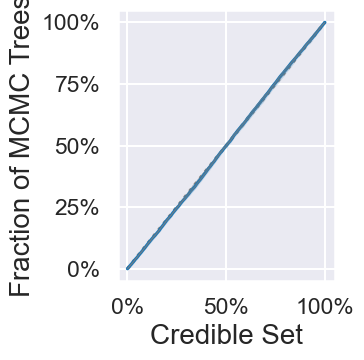

full-matrix-mle


/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/4075001225.py:15: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


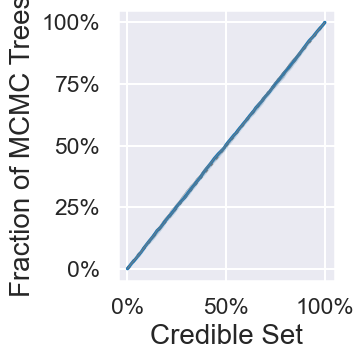

gamma


/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/4075001225.py:15: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


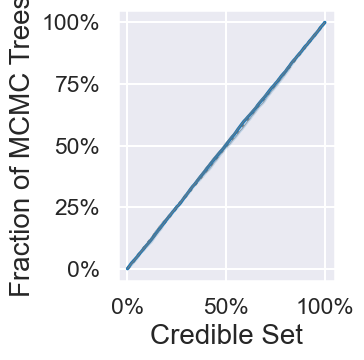

gamma-corr


/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/4075001225.py:15: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


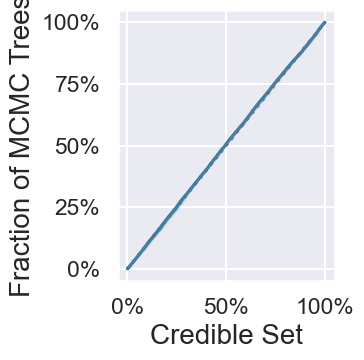

log-normal


/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/4075001225.py:15: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


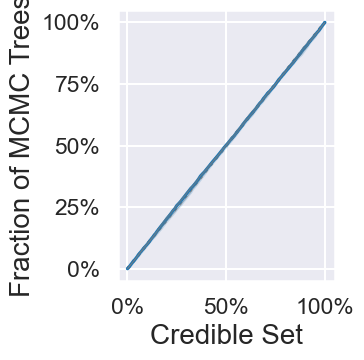

log-normal-corr


/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/4075001225.py:15: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


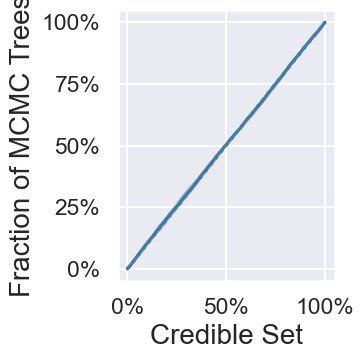

sb-beta


/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/4075001225.py:15: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


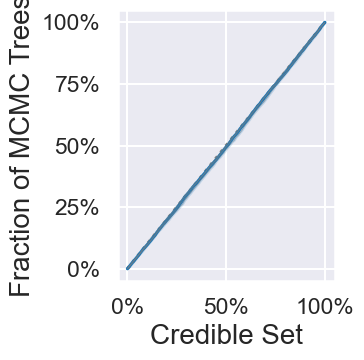

sb-beta-per-clade


/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/4075001225.py:15: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


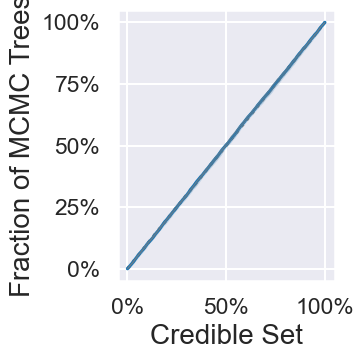

In [165]:
for distribution in df_ref_credible_sets.distribution.unique():
    print(distribution)
    
    plt.figure(figsize=(4,4))
    
    plt.plot([0, 1], [0, 1], color="grey", linestyle="dotted")

    fig = sns.lineplot(
        df_ref_credible_sets[df_ref_credible_sets.distribution == distribution],
        y="ecdf", x="credible_set",
        estimator="median", errorbar=("pi", 95)
    )
    
    sampled_files = np.random.choice(df_ref_credible_sets.file.unique(), size=15)
    sns.lineplot(
        df_ref_credible_sets[(df_ref_credible_sets.distribution == distribution) & (df_ref_credible_sets.file.isin(sampled_files))],
        y="ecdf", x="credible_set", hue="file",
        palette=sns.color_palette(['gray']), linewidth=0.25
    )

    fig.yaxis.set_major_formatter(PercentFormatter(1))
    fig.xaxis.set_major_formatter(PercentFormatter(1))

    plt.xlabel("Credible Set")
    plt.ylabel("Fraction of MCMC Trees")
    
    plt.legend().remove()
    
    plt.tight_layout()
    plt.savefig(PLOTS_PATH / f"{PLOT_PREFIX}-credible-sets-{distribution}.png", dpi=250)
    
    plt.show()

## Credible Sets

In [166]:
ecdf_credible_sets_dict = {
    "file": [],
    "distribution": [],
    "credible_set": [],
    "ecdf": [],
}


for credible_sets_file in OUTPUT_PATH.glob(f"{PREFIX}*_credible_sets.log"):    
    df = pd.read_csv(credible_sets_file, sep=";")
    
    stats_file = OUTPUT_PATH / credible_sets_file.name.replace("_credible_sets.log", "_stats.log")
    entropy = entropy_per_file.get(stats_file.name, None)
    
    for dist, df_distribution in df.groupby("distribution"):
        ecdf_func = stats.ecdf(df_distribution["sample_credible_set"])
        
        for c in range(101):
            ecdf_value = float(ecdf_func.cdf.evaluate(c / 100))
            
            ecdf_credible_sets_dict["file"].append(credible_sets_file)
            ecdf_credible_sets_dict["distribution"].append(dist)
            ecdf_credible_sets_dict["credible_set"].append(c / 100)
            ecdf_credible_sets_dict["ecdf"].append(ecdf_value)
        
df_credible_sets = pd.DataFrame(ecdf_credible_sets_dict)

dirichlet


/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/2490403172.py:15: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


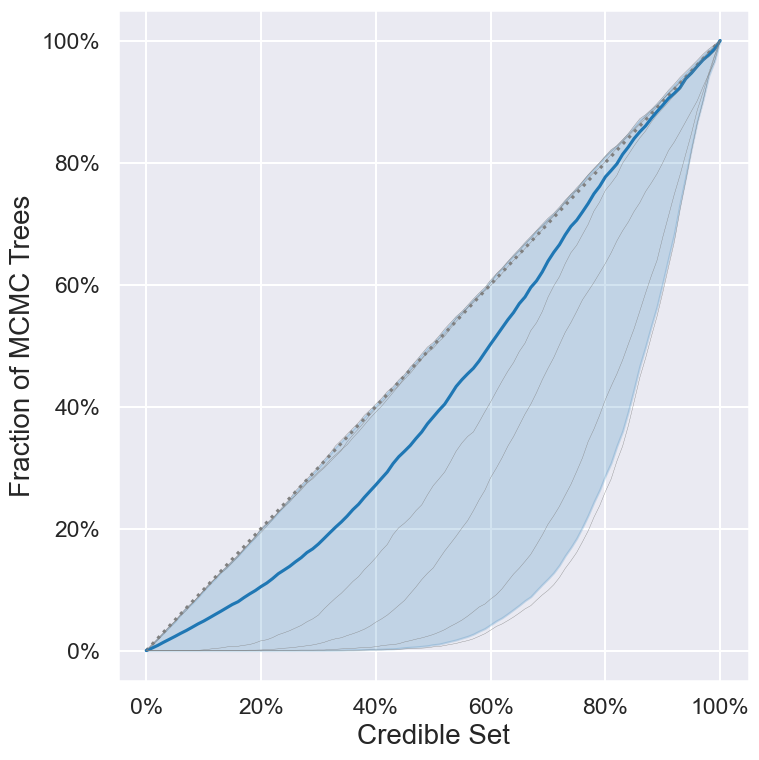

full-matrix-mle


/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/2490403172.py:15: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


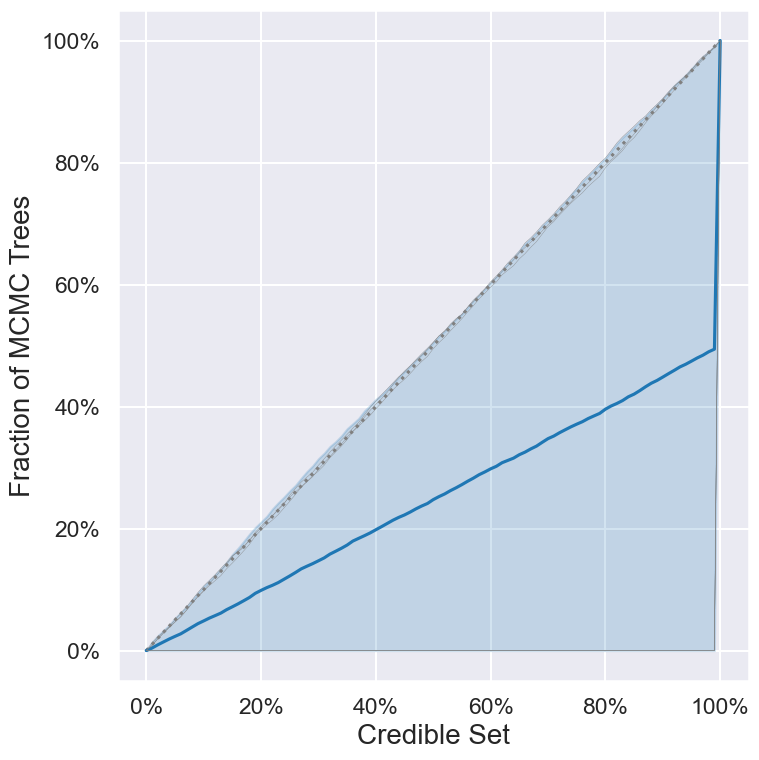

gamma


/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/2490403172.py:15: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


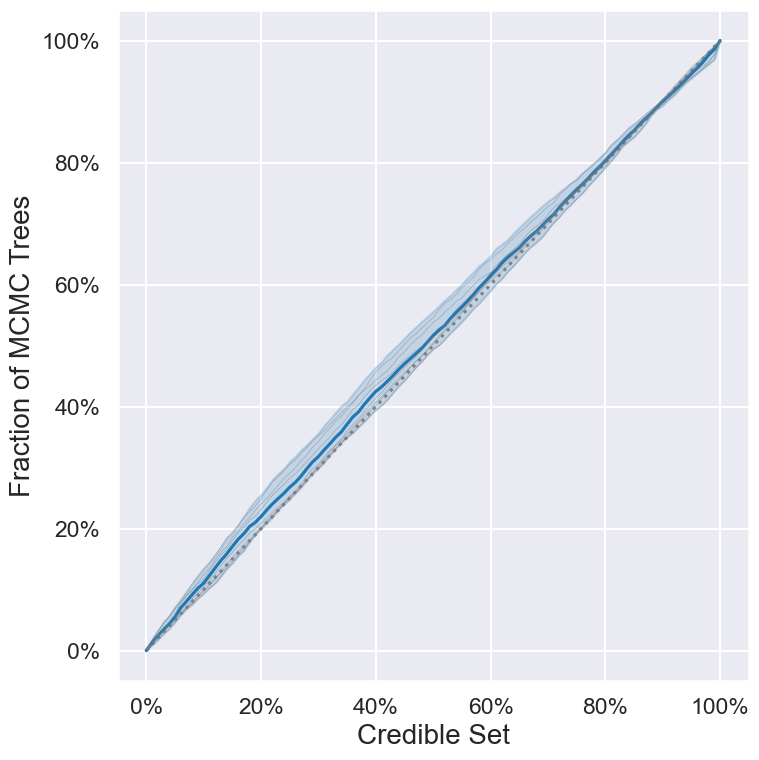

gamma-corr


/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/2490403172.py:15: UserWarning: 
The palette list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


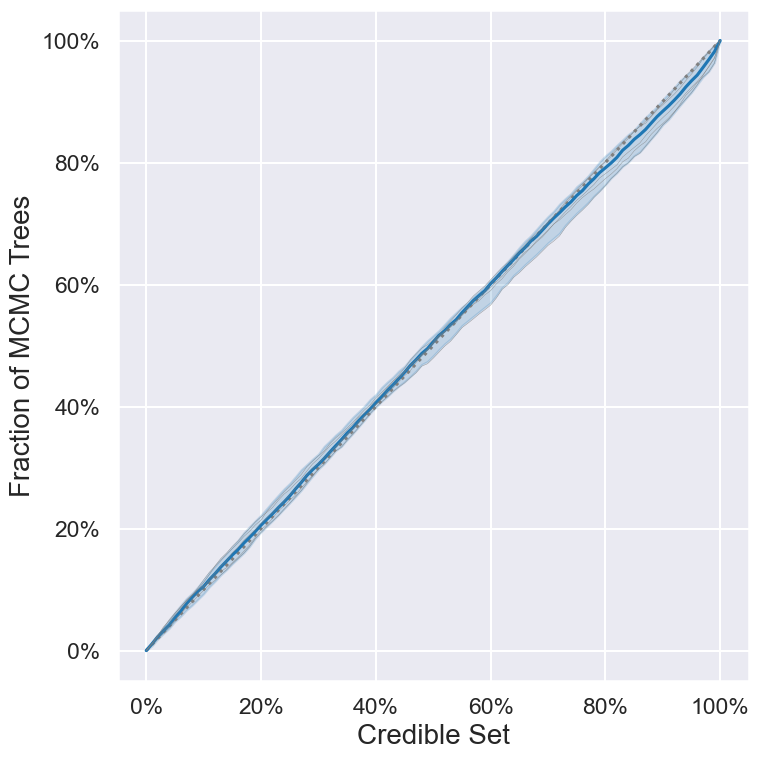

log-normal


/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/2490403172.py:15: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


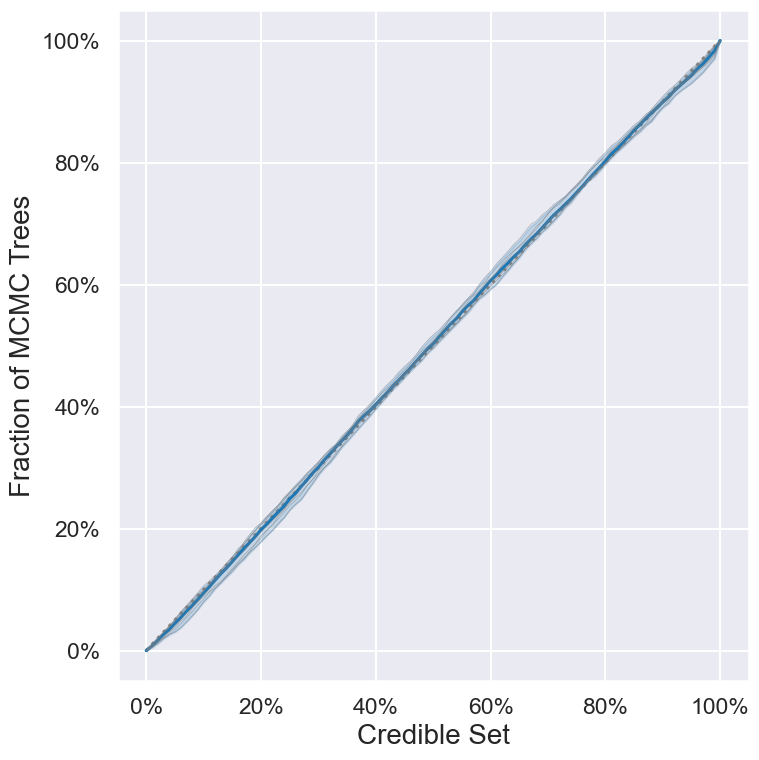

log-normal-corr


/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/2490403172.py:15: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


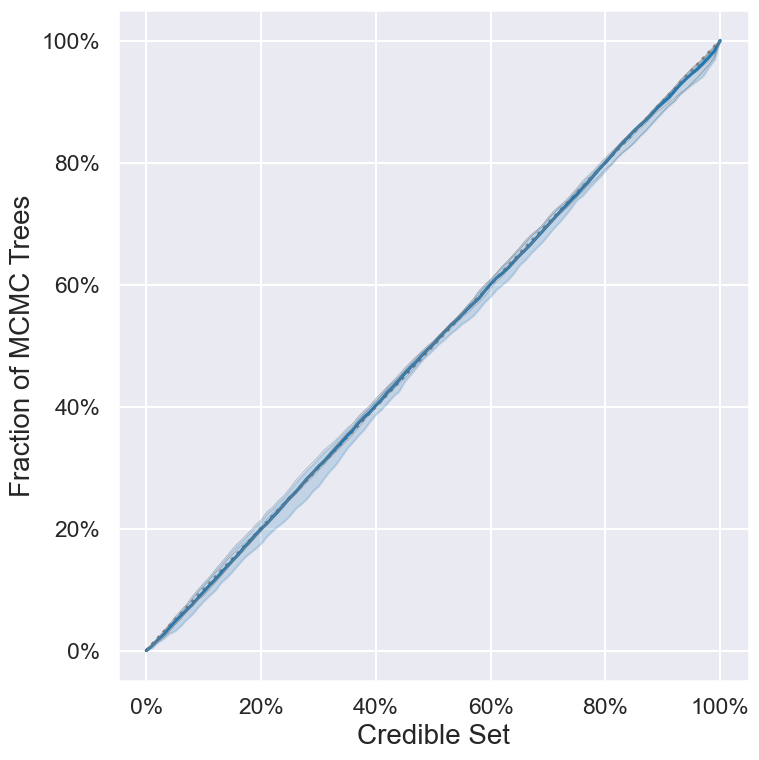

sb-beta


/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/2490403172.py:15: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


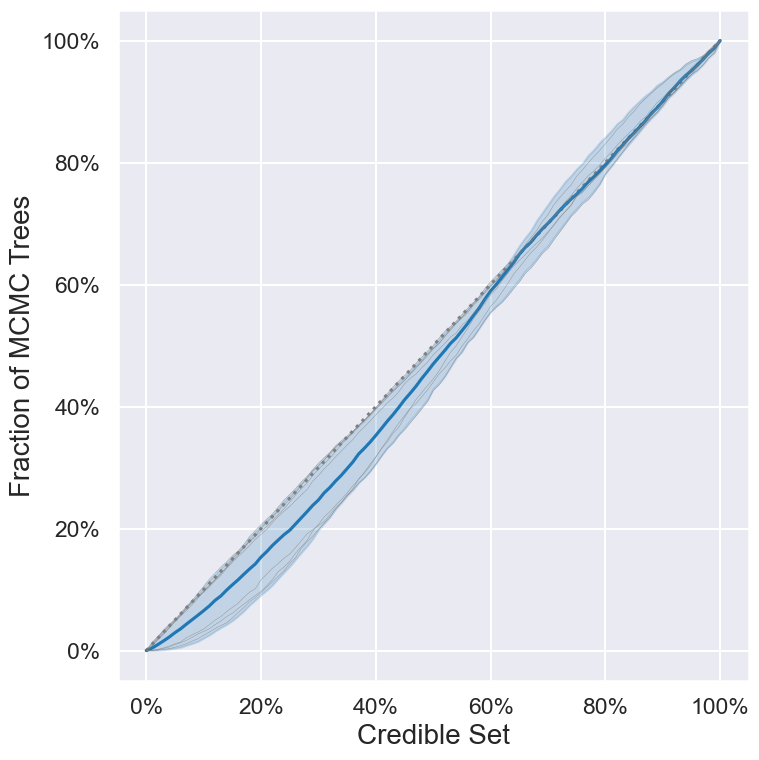

sb-beta-per-clade


/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/2490403172.py:15: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


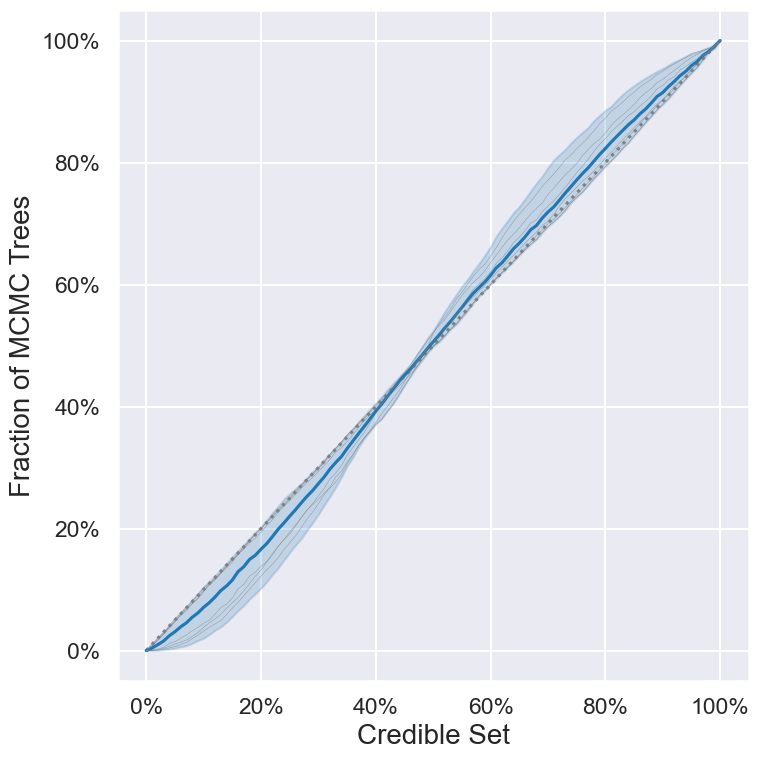

In [167]:
for distribution in df_credible_sets.distribution.unique():
    print(distribution)
    
    plt.figure(figsize=(8,8))
    
    plt.plot([0, 1], [0, 1], color="grey", linestyle="dotted")

    fig = sns.lineplot(
        df_credible_sets[df_credible_sets.distribution == distribution],
        y="ecdf", x="credible_set",
        estimator="median", errorbar=("pi", 95)
    )
    
    sampled_files = np.random.choice(df_credible_sets.file.unique(), size=15)
    sns.lineplot(
        df_credible_sets[(df_credible_sets.distribution == distribution) & (df_credible_sets.file.isin(sampled_files))],
        y="ecdf", x="credible_set", hue="file",
        palette=sns.color_palette(['gray']), linewidth=0.25
    )

    fig.yaxis.set_major_formatter(PercentFormatter(1))
    fig.xaxis.set_major_formatter(PercentFormatter(1))

    plt.xlabel("Credible Set")
    plt.ylabel("Fraction of MCMC Trees")
    
    plt.legend().remove()
    
    plt.tight_layout()
    plt.savefig(PLOTS_PATH / f"{PLOT_PREFIX}-credible-sets-{distribution}.png", dpi=250)
    
    plt.show()

## Point estimates

In [168]:
from Bio.Phylo.BaseTree import Tree

from src.utils.tree_utils import get_taxa_names
from src.distribution_analysis.process_tree import get_observed_nodes


def rooted_branch_score(tree_1: Tree, tree_2: Tree) -> float:
    taxa_names = get_taxa_names(tree_1)

    nodes_1, _ = get_observed_nodes([tree_1], taxa_names)
    nodes_2, _ = get_observed_nodes([tree_2], taxa_names)

    clades_to_node_1 = {node.node_bitstring: node for node in nodes_1}
    clades_to_node_2 = {node.node_bitstring: node for node in nodes_2}

    rbs = 0.0

    all_clades = set(clades_to_node_1.keys()) | set(clades_to_node_2.keys())

    for clade in all_clades:
        if node_1 := clades_to_node_1.get(clade):
            branch_1 = node_1.height - node_1.parent_height
        else:
            continue

        if node_2 := clades_to_node_2.get(clade):
            branch_2 = node_2.height - node_2.parent_height
        else:
            continue

        rbs += (branch_1 - branch_2)**2

    return rbs

In [169]:
TRUE_TREE_DIR = Path("data/lphy")

df_point_estimates_dict = {"distribution": [], "file": [], "score": []}

for tree_file in tqdm(list(OUTPUT_PATH.glob(f"{PREFIX}*point_estimate.trees"))):
    point_estimates = load_trees_from_file(tree_file)
    
    true_tree = load_trees_from_file(
        TRUE_TREE_DIR / tree_file.name.replace("_point_estimate", "_true_phi")
    )[0]
    
    for point_estimate in point_estimates:
        for terminal in point_estimate.get_terminals():
            terminal.name = terminal.name.replace('"', "")
        
        df_point_estimates_dict["file"].append(tree_file)
        df_point_estimates_dict["distribution"].append(point_estimate.name.replace("'", ""))
        df_point_estimates_dict["score"].append(rooted_branch_score(true_tree, point_estimate))

df_point_estimates = pd.DataFrame(df_point_estimates_dict)

100%|██████████| 4/4 [00:00<00:00, 103.28it/s]


In [170]:
df_point_estimates = df_point_estimates.sort_values("score")
df_point_estimates["score_rank"] = (
    df_point_estimates
    .groupby("file")
    .cumcount() + 1
)
df_point_estimates = df_point_estimates.reset_index()

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/397240638.py:3: UserWarning: The palette list has more values (12) than needed (9), which may not be intended.
  ax = sns.displot(


<Figure size 1400x1000 with 0 Axes>

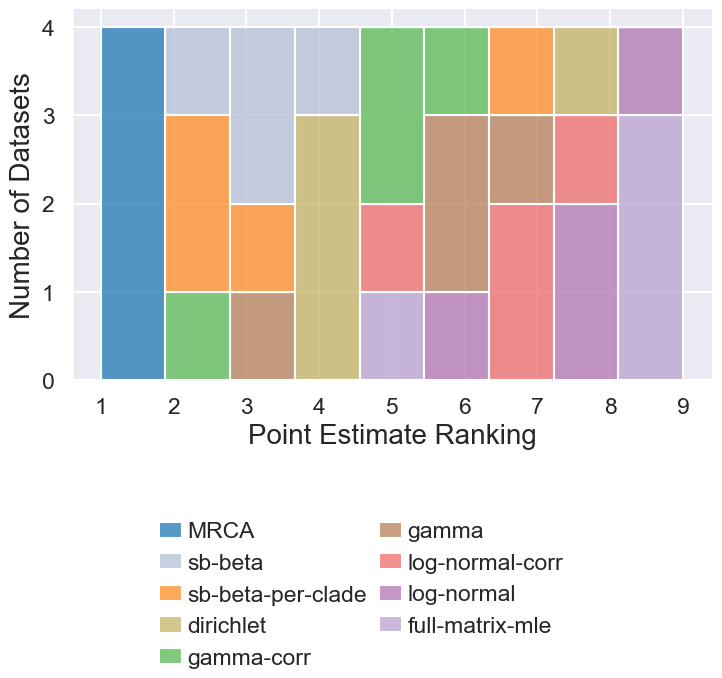

In [171]:
plt.figure(figsize=(14,10))

ax = sns.displot(
    data=df_point_estimates, x="score_rank", hue="distribution",
    multiple='stack', bins=num_methods, palette=palette + [plt.cm.tab20(6)]
)


sns.move_legend(
    ax, "lower center", bbox_to_anchor=(0.5, -0.4), ncol=2, title=None, frameon=False,
    borderpad=0, columnspacing=0.5, handletextpad=0.25, handlelength=1.0
)
plt.xlabel("Point Estimate Ranking")
plt.ylabel("Number of Datasets")

plt.tight_layout()
ax.savefig(PLOTS_PATH / f"{PLOT_PREFIX}-point-estimates-ranking.png", dpi=250)

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/3592136807.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_2902/3592136807.py:3: UserWarning: The palette list has more values (12) than needed (9), which may not be intended.
  sns.boxplot(


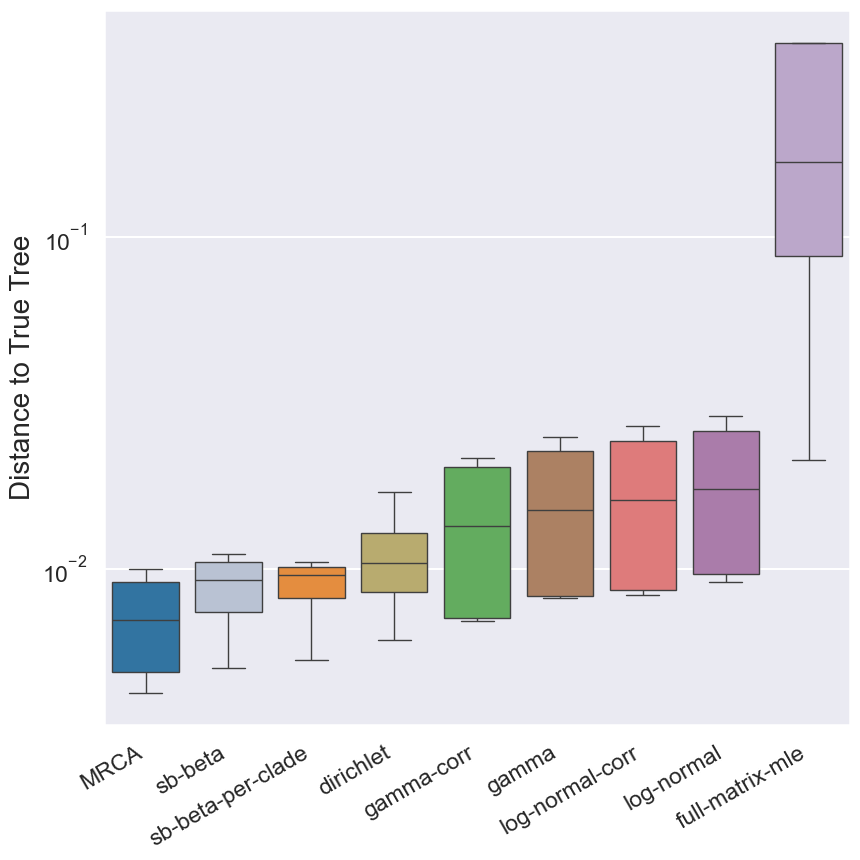

In [172]:
plt.figure(figsize=(9,9))

sns.boxplot(
    df_point_estimates,
    x="distribution",
    y="score",
    showfliers=False,
    palette=palette + [plt.cm.tab20(6)]
)

plt.xticks(rotation=30, ha="right")

plt.xlabel(None)
plt.ylabel("Distance to True Tree")

plt.yscale("log")

plt.tight_layout()
plt.savefig(PLOTS_PATH / f"{PLOT_PREFIX}-point-estimates.png", dpi=250)